In [131]:
#compare SNR in high b-values between Erin's and other sequences:
#based on https://docs.dipy.org/1.0.0/examples_built/snr_in_cc.html

In [136]:
"""
Conclusion: BASR indeed shows lower SNR (and more noise) than trestore, probably related to bipolar gradients.
To make a valid comparison we probably need data using the exact same sequence parameters and directions and compare bipolar vs monopolar
Could be a very short sequence (e.g., 6 directions or so)
"""

'\nConclusion: BASR indeed shows lower SNR (and more noise) than trestore, probably related to bipolar gradients.\nTo make a valid comparison we probably need data using the exact same sequence parameters and directions and compare bipolar vs monopolar\nCould be a very short sequence (e.g., 6 directions or so)\n'

In [132]:
#principle:
#select a part of the brain that shows a one-direction fibre bundle (eg., CC)
#compute the average signal (across voxels) for the directions that are perpendicular to that fibre bundle (e.g., CC)
#divide that by the standard deviation of what is non-brain material (std across all voxels and images, only upper-part of image included to exclude eyes and mouth etc)

In [98]:
from __future__ import division, print_function
import nibabel as nib
from dipy.data import fetch_stanford_hardi, read_stanford_hardi
from dipy.segment.mask import median_otsu
from dipy.reconst.dti import TensorModel
from dipy.io.gradients import read_bvals_bvecs
from dipy.core.gradients import gradient_table
from dipy.segment.mask import segment_from_cfa
from dipy.segment.mask import bounding_box
from scipy.ndimage.morphology import binary_dilation

/tmp/ipykernel_654122/2028023856.py:10: DeprecationWarning: Please import `binary_dilation` from the `scipy.ndimage` namespace; the `scipy.ndimage.morphology` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.morphology import binary_dilation


In [99]:
import numpy as np

In [ ]:
#extract b0 and b3000:
#BASR:
#first, everything was concatenated, and then files were outputted:
#!dwiextract sub-BASRC10_ses-expt_dir-PA_run-02_dwi_concat.mif.gz sub-BASRC10_ses-expt_dir-PA_run-02_dwi_concat_b3000.nii.gz -shells 0,3000 -export_grad_fsl sub-BASRC10_ses-expt_dir-PA_run-02_dwi_concat_b3000.bvec sub-BASRC10_ses-expt_dir-PA_run-02_dwi_concat_b3000.bval
#trestore:
#!dwiextract sub-205_ses-001_dir-PA_run-01_dwi.nii.gz sub-205_ses-001_dir-PA_run-01_dwi_b3000.nii.gz -fslgrad sub-205_ses-001_dir-PA_run-01_dwi.bvec sub-205_ses-001_dir-PA_run-01_dwi.bval -shells 0,3000 -export_grad_fsl sub-205_ses-001_dir-PA_run-01_dwi_b3000.bvec sub-205_ses-001_dir-PA_run-01_dwi_b3000.bval

In [137]:
image_path_BASR = '~/Desktop/QC_code/SNR_in_DWI/BASR/sub-BASRC10_ses-expt_dir-PA_run-02_dwi_concat_b3000.nii.gz'
image_path_trestore = '~/Desktop/QC_code/SNR_in_DWI/trestore/sub-205_ses-001_dir-PA_run-01_dwi_b3000.nii.gz'

In [138]:
dwi_BASR = nib.load(image_path_BASR)
dwi_trestore = nib.load(image_path_trestore)

In [144]:
#read BASR data:
data_BASR = dwi_BASR.get_fdata()
affine_BASR = dwi_BASR.affine

bvals_BASR, bvecs_BASR = read_bvals_bvecs('/home/hannes-almgren/Desktop/QC_code/SNR_in_DWI/BASR/sub-BASRC10_ses-expt_dir-PA_run-02_dwi_concat_b3000.bval', '/home/hannes-almgren/Desktop/QC_code/SNR_in_DWI/BASR/sub-BASRC10_ses-expt_dir-PA_run-02_dwi_concat_b3000.bvec')
gtab_BASR = gradient_table(bvals_BASR, bvecs=bvecs_BASR)

#median_otsu does not do a good job
#to create brainmask, run:
#!bet sub-BASRC10_ses-expt_dir-AP_run-01_dwi.nii.gz bet_b0_brain -f 0.25 -m
#!mrcalc sub-BASRC10_ses-expt_dir-AP_run-01_dwi.nii.gz bet_b0_brain_mask.nii.gz -multiply sub-BASRC10_ses-expt_dir-AP_run-01_dwi_brain.nii.gz
b0_mask_BASR = nib.load('/home/hannes-almgren/Desktop/QC_code/SNR_in_DWI/BASR/sub-BASRC10_ses-expt_dir-AP_run-01_dwi_brain.nii.gz').get_fdata()
mask_BASR = nib.load('/home/hannes-almgren/Desktop/QC_code/SNR_in_DWI/BASR/bet_b0_brain_mask.nii.gz').get_fdata()

print('Computing tensors...')
tenmodel_BASR = TensorModel(gtab_BASR)
tensorfit_BASR = tenmodel_BASR.fit(data_BASR, mask=mask_BASR)


Computing tensors...


In [145]:
#read trestore data:
data_trestore = dwi_trestore.get_fdata()
affine_trestore = dwi_trestore.affine

bvals_trestore, bvecs_trestore = read_bvals_bvecs('/home/hannes-almgren/Desktop/QC_code/SNR_in_DWI/trestore/sub-205_ses-001_dir-PA_run-01_dwi_b3000.bval', '/home/hannes-almgren/Desktop/QC_code/SNR_in_DWI/trestore/sub-205_ses-001_dir-PA_run-01_dwi_b3000.bvec')
gtab_trestore = gradient_table(bvals_trestore, bvecs=bvecs_trestore)

#median_otsu does not do a good job
#to create brainmask, run:
#!bet sub-205_ses-001_dir-PA_run-01_dwi.nii.gz bet_b0_brain -f 0.25 -m
#!mrcalc sub-205_ses-001_dir-PA_run-01_dwi.nii.gz bet_b0_brain_mask.nii.gz -multiply sub-205_ses-001_dir-PA_run-01_dwi_brain.nii.gz
b0_mask_trestore = nib.load('/home/hannes-almgren/Desktop/QC_code/SNR_in_DWI/trestore/sub-205_ses-001_dir-PA_run-01_dwi_brain.nii.gz').get_fdata()
mask_trestore = nib.load('/home/hannes-almgren/Desktop/QC_code/SNR_in_DWI/trestore/bet_b0_brain_mask.nii.gz').get_fdata()

print('Computing tensors...')
tenmodel_trestore = TensorModel(gtab_trestore)
tensorfit_trestore = tenmodel_trestore.fit(data_trestore, mask=mask_trestore)


Computing tensors...


In [153]:
#BASR
print('Computing worst-case/best-case SNR using the corpus callosum...')
threshold = (0.6, 1, 0, 0.2, 0, 0.2)
CC_box_BASR = np.zeros_like(data_BASR[..., 0])

mins, maxs = bounding_box(mask_BASR)
mins = np.array(mins)
maxs = np.array(maxs)
diff = (maxs - mins) // 4
bounds_min = mins + diff
bounds_max = maxs - diff

CC_box_BASR[bounds_min[0]:bounds_max[0],
       bounds_min[1]:bounds_max[1],
       bounds_min[2]:bounds_max[2]] = 1

mask_cc_part_BASR, cfa_BASR = segment_from_cfa(tensorfit_BASR, CC_box_BASR, threshold,
                                     return_cfa=True)

cfa_img_BASR = nib.Nifti1Image((cfa_BASR*255).astype(np.uint8), affine_BASR)
mask_cc_part_img_BASR = nib.Nifti1Image(mask_cc_part_BASR.astype(np.uint8), affine_BASR)
nib.save(mask_cc_part_img_BASR, '/home/hannes-almgren/Desktop/QC_code/SNR_in_DWI/BASR/mask_CC_part.nii.gz')
#a few non-CC voxels, but is a small minority so let's ignore it for now

Computing worst-case/best-case SNR using the corpus callosum...


In [149]:
#trestore
print('Computing worst-case/best-case SNR using the corpus callosum...')
threshold = (0.6, 1, 0, 0.2, 0, 0.2)
CC_box_trestore = np.zeros_like(data_trestore[..., 0])

mins, maxs = bounding_box(mask_trestore)
mins = np.array(mins)
maxs = np.array(maxs)
diff = (maxs - mins) // 4
bounds_min = mins + diff
bounds_max = maxs - diff

CC_box_trestore[bounds_min[0]:bounds_max[0],
       bounds_min[1]:bounds_max[1],
       bounds_min[2]:bounds_max[2]] = 1

mask_cc_part_trestore, cfa_trestore = segment_from_cfa(tensorfit_trestore, CC_box_trestore, threshold,
                                     return_cfa=True)

cfa_img_trestore = nib.Nifti1Image((cfa_trestore*255).astype(np.uint8), affine_trestore)
mask_cc_part_img_trestore = nib.Nifti1Image(mask_cc_part_trestore.astype(np.uint8), affine_trestore)
nib.save(mask_cc_part_img_trestore, '/home/hannes-almgren/Desktop/QC_code/SNR_in_DWI/trestore/mask_CC_part.nii.gz')
#a few non-CC voxels, but is a small minority so let's ignore it for now

Computing worst-case/best-case SNR using the corpus callosum...


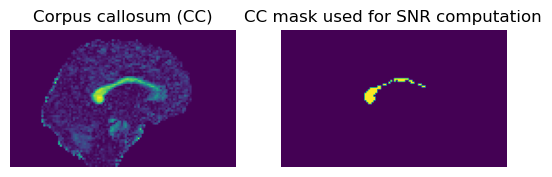

In [160]:
#BASR
import matplotlib.pyplot as plt
region = 60
fig = plt.figure('Corpus callosum segmentation')
plt.subplot(1, 2, 1)
plt.title("Corpus callosum (CC)")
plt.axis('off')
red = cfa_BASR[..., 0]
plt.imshow(np.rot90(red[region, ...]))

plt.subplot(1, 2, 2)
plt.title("CC mask used for SNR computation")
plt.axis('off')
plt.imshow(np.rot90(mask_cc_part_BASR[region, ...]))
fig.savefig("CC_segmentation.png", bbox_inches='tight')

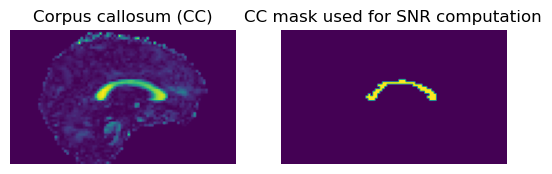

In [155]:
#trestore
import matplotlib.pyplot as plt
region = 48
fig = plt.figure('Corpus callosum segmentation')
plt.subplot(1, 2, 1)
plt.title("Corpus callosum (CC)")
plt.axis('off')
red = cfa_trestore[..., 0]
plt.imshow(np.rot90(red[region, ...]))

plt.subplot(1, 2, 2)
plt.title("CC mask used for SNR computation")
plt.axis('off')
plt.imshow(np.rot90(mask_cc_part_trestore[region, ...]))
fig.savefig("CC_segmentation.png", bbox_inches='tight')

In [161]:
mean_signal_BASR = np.mean(data_BASR[mask_cc_part_BASR], axis=0)
mean_signal_trestore = np.mean(data_trestore[mask_cc_part_trestore], axis=0)

In [162]:
#BASR:
mask_noise_BASR = binary_dilation(mask_BASR, iterations=10)
mask_noise_BASR[..., :mask_noise_BASR.shape[-1]//2] = 1 #only includes noise from upper part of brain
mask_noise_BASR = ~mask_noise_BASR
mask_noise_img_BASR = nib.Nifti1Image(mask_noise_BASR.astype(np.uint8), affine_BASR)
nib.save(mask_noise_img_BASR, '/home/hannes-almgren/Desktop/QC_code/SNR_in_DWI/BASR/mask_noise.nii.gz')

noise_std_BASR = np.std(data_BASR[mask_noise_BASR, :]) #take the standard deviation of non-brain matter (upper side of image only) across all voxels AND all images
print('Noise standard deviation sigma= ', noise_std_BASR)

Noise standard deviation sigma=  2.0474858105336766


In [163]:
#trestore:
mask_noise_trestore = binary_dilation(mask_trestore, iterations=10)
mask_noise_trestore[..., :mask_noise_trestore.shape[-1]//2] = 1 #only includes noise from upper part of brain
mask_noise_trestore = ~mask_noise_trestore
mask_noise_img_trestore = nib.Nifti1Image(mask_noise_trestore.astype(np.uint8), affine_trestore)
nib.save(mask_noise_img_trestore, '/home/hannes-almgren/Desktop/QC_code/SNR_in_DWI/trestore/mask_noise.nii.gz')

noise_std_trestore = np.std(data_trestore[mask_noise_trestore, :]) #take the standard deviation of non-brain matter (upper side of image only) across all voxels AND all images
print('Noise standard deviation sigma= ', noise_std_trestore)

Noise standard deviation sigma=  0.6198408112905853


In [166]:
# BASR
#principle:
#select a part of the brain that shows a one-direction fibre bundle (eg., CC)
#compute the average signal (across voxels) for the directions that are perpendicular to that fibre bundle (e.g., CC)
#divide that by the standard deviation of what is non-brain material (std across all voxels and images, only upper-part of image included to exclude eyes and mouth etc)
# Exclude null bvecs from the search
idx = np.sum(gtab_BASR.bvecs, axis=-1) == 0
gtab_BASR.bvecs[idx] = np.inf
axis_X = np.argmin(np.sum((gtab_BASR.bvecs-np.array([1, 0, 0]))**2, axis=-1)) #We select the x-coordinate for which the bvec is closest to 1,0,0 [Euclidian distance]
axis_Y = np.argmin(np.sum((gtab_BASR.bvecs-np.array([0, 1, 0]))**2, axis=-1)) #We select the y-coordinate for which the bvec is closest to 0,1,0 [Euclidian distance]
axis_Z = np.argmin(np.sum((gtab_BASR.bvecs-np.array([0, 0, 1]))**2, axis=-1)) #We select the z-coordinate for which the bvec is closest to 0,0,1 [Euclidian distance]

for direction in [0, axis_X, axis_Y, axis_Z]:
    SNR = mean_signal_BASR[direction]/noise_std_BASR
    if direction == 0:
        print("SNR for the b=0 image is :", SNR)
    else:
        print("SNR for diffusion direction", direction, " ",
              gtab_BASR.bvecs[direction], "is :", SNR)

SNR for the b=0 image is : 108.21791621089211
SNR for diffusion direction 43   [ 0.97888605 -0.18770001  0.0809371 ] is : 11.391822035837915
SNR for diffusion direction 69   [-0.21850898  0.97189393  0.08761289] is : 42.91572087144464
SNR for diffusion direction 24   [-0.0611097  0.269737   0.960993 ] is : 50.497956638910495


In [167]:
#trestore
#principle:
#select a part of the brain that shows a one-direction fibre bundle (eg., CC)
#compute the average signal (across voxels) for the directions that are perpendicular to that fibre bundle (e.g., CC)
#divide that by the standard deviation of what is non-brain material (std across all voxels and images, only upper-part of image included to exclude eyes and mouth etc)
# Exclude null bvecs from the search
idx = np.sum(gtab_trestore.bvecs, axis=-1) == 0
gtab_trestore.bvecs[idx] = np.inf
axis_X = np.argmin(np.sum((gtab_trestore.bvecs-np.array([1, 0, 0]))**2, axis=-1)) #We select the x-coordinate for which the bvec is closest to 1,0,0 [Euclidian distance]
axis_Y = np.argmin(np.sum((gtab_trestore.bvecs-np.array([0, 1, 0]))**2, axis=-1)) #We select the y-coordinate for which the bvec is closest to 0,1,0 [Euclidian distance]
axis_Z = np.argmin(np.sum((gtab_trestore.bvecs-np.array([0, 0, 1]))**2, axis=-1)) #We select the z-coordinate for which the bvec is closest to 0,0,1 [Euclidian distance]

for direction in [0, axis_X, axis_Y, axis_Z]:
    SNR = mean_signal_trestore[direction]/noise_std_trestore
    if direction == 0:
        print("SNR for the b=0 image is :", SNR)
    else:
        print("SNR for diffusion  direction", direction, " ",
              gtab_trestore.bvecs[direction], "is :", SNR)

SNR for the b=0 image is : 359.53618987413455
SNR for diffusion  direction 14   [ 0.99214999 -0.0758295  -0.0994398 ] is : 19.578811826002088
SNR for diffusion  direction 61   [-0.07341384  0.97138255 -0.22589013] is : 149.38151618026873
SNR for diffusion  direction 38   [ 0.13356604 -0.03853891  0.99029029] is : 156.2143901061218


In [174]:
"""
MND data also shows a lot fo noise. However, here max b-value is 2500 (so is not directly comparable to retsotre/BASR data)
But we can still compare it (e.g., if b2500 less SNR than b3000 than that is definitely an issue)
"""

'\nMND data also shows a lot fo noise. However, here max b-value is 2500\n'

In [175]:
image_path_MND = '~/Desktop/QC_code/SNR_in_DWI/MND/_NODDI_DTI_6b0_30b1000_60b2500_20250402130517_28_2500.nii.gz'

In [177]:
dwi_MND = nib.load(image_path_MND)

In [178]:
#read MND data:
data_MND = dwi_MND.get_fdata()
affine_MND = dwi_MND.affine

bvals_MND, bvecs_MND = read_bvals_bvecs('/home/hannes-almgren/Desktop/QC_code/SNR_in_DWI/MND/_NODDI_DTI_6b0_30b1000_60b2500_20250402130517_28_2500.bval', '/home/hannes-almgren/Desktop/QC_code/SNR_in_DWI/MND/_NODDI_DTI_6b0_30b1000_60b2500_20250402130517_28_2500.bvec')
gtab_MND = gradient_table(bvals_MND, bvecs=bvecs_MND)

#median_otsu does not do a good job
#to create brainmask, run:
#!bet _NODDI_DTI_6b0_30b1000_60b2500_20250402130517_28_2500.nii.gz bet_b0_brain -f 0.25 -m
#!mrcalc _NODDI_DTI_6b0_30b1000_60b2500_20250402130517_28_2500.nii.gz bet_b0_brain_mask.nii.gz -multiply _NODDI_DTI_6b0_30b1000_60b2500_20250402130517_28_2500_brain.nii.gz
b0_mask_MND = nib.load('/home/hannes-almgren/Desktop/QC_code/SNR_in_DWI/MND/_NODDI_DTI_6b0_30b1000_60b2500_20250402130517_28_2500_brain.nii.gz').get_fdata()
mask_MND = nib.load('/home/hannes-almgren/Desktop/QC_code/SNR_in_DWI/MND/bet_b0_brain_mask.nii.gz').get_fdata()

print('Computing tensors...')
tenmodel_MND = TensorModel(gtab_MND)
tensorfit_MND = tenmodel_MND.fit(data_MND, mask=mask_MND)


Computing tensors...


In [180]:
#MND
print('Computing worst-case/best-case SNR using the corpus callosum...')
threshold = (0.7, 1, 0, 0.2, 0, 0.2)
CC_box_MND = np.zeros_like(data_MND[..., 0])

mins, maxs = bounding_box(mask_MND)
mins = np.array(mins)
maxs = np.array(maxs)
diff = (maxs - mins) // 4
bounds_min = mins + diff
bounds_max = maxs - diff

CC_box_MND[bounds_min[0]:bounds_max[0],
       bounds_min[1]:bounds_max[1],
       bounds_min[2]:bounds_max[2]] = 1

mask_cc_part_MND, cfa_MND = segment_from_cfa(tensorfit_MND, CC_box_MND, threshold,
                                     return_cfa=True)

cfa_img_MND = nib.Nifti1Image((cfa_MND*255).astype(np.uint8), affine_MND)
mask_cc_part_img_MND = nib.Nifti1Image(mask_cc_part_MND.astype(np.uint8), affine_MND)
nib.save(mask_cc_part_img_MND, '/home/hannes-almgren/Desktop/QC_code/SNR_in_DWI/MND/mask_CC_part.nii.gz')
#a few non-CC voxels, but is a small minority so let's ignore it for now

Computing worst-case/best-case SNR using the corpus callosum...


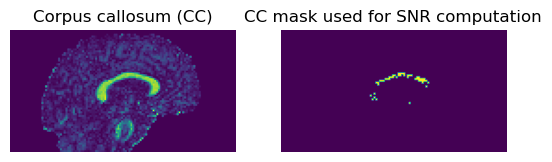

In [184]:
#BASR
import matplotlib.pyplot as plt
region = 59
fig = plt.figure('Corpus callosum segmentation')
plt.subplot(1, 2, 1)
plt.title("Corpus callosum (CC)")
plt.axis('off')
red = cfa_MND[..., 0]
plt.imshow(np.rot90(red[region, ...]))

plt.subplot(1, 2, 2)
plt.title("CC mask used for SNR computation")
plt.axis('off')
plt.imshow(np.rot90(mask_cc_part_MND[region, ...]))
fig.savefig("CC_segmentation.png", bbox_inches='tight')

In [185]:
mean_signal_MND = np.mean(data_MND[mask_cc_part_MND], axis=0)

In [186]:
#MND:
mask_noise_MND = binary_dilation(mask_MND, iterations=10)
mask_noise_MND[..., :mask_noise_MND.shape[-1]//2] = 1 #only includes noise from upper part of brain
mask_noise_MND = ~mask_noise_MND
mask_noise_img_MND = nib.Nifti1Image(mask_noise_MND.astype(np.uint8), affine_MND)
nib.save(mask_noise_img_MND, '/home/hannes-almgren/Desktop/QC_code/SNR_in_DWI/MND/mask_noise.nii.gz')

noise_std_MND = np.std(data_MND[mask_noise_MND, :]) #take the standard deviation of non-brain matter (upper side of image only) across all voxels AND all images
print('Noise standard deviation sigma= ', noise_std_MND)

Noise standard deviation sigma=  3.1680274817763885


In [187]:
# MND
#principle:
#select a part of the brain that shows a one-direction fibre bundle (eg., CC)
#compute the average signal (across voxels) for the directions that are perpendicular to that fibre bundle (e.g., CC)
#divide that by the standard deviation of what is non-brain material (std across all voxels and images, only upper-part of image included to exclude eyes and mouth etc)
# Exclude null bvecs from the search
idx = np.sum(gtab_MND.bvecs, axis=-1) == 0
gtab_MND.bvecs[idx] = np.inf
axis_X = np.argmin(np.sum((gtab_MND.bvecs-np.array([1, 0, 0]))**2, axis=-1)) #We select the x-coordinate for which the bvec is closest to 1,0,0 [Euclidian distance]
axis_Y = np.argmin(np.sum((gtab_MND.bvecs-np.array([0, 1, 0]))**2, axis=-1)) #We select the y-coordinate for which the bvec is closest to 0,1,0 [Euclidian distance]
axis_Z = np.argmin(np.sum((gtab_MND.bvecs-np.array([0, 0, 1]))**2, axis=-1)) #We select the z-coordinate for which the bvec is closest to 0,0,1 [Euclidian distance]

for direction in [0, axis_X, axis_Y, axis_Z]:
    SNR = mean_signal_MND[direction]/noise_std_MND
    if direction == 0:
        print("SNR for the b=0 image is :", SNR)
    else:
        print("SNR for diffusion direction", direction, " ",
              gtab_MND.bvecs[direction], "is :", SNR)

SNR for the b=0 image is : 83.21815239427077
SNR for diffusion direction 37   [ 0.99827783 -0.0202686   0.05505059] is : 8.551267851654899
SNR for diffusion direction 32   [-0.11222602  0.95071219 -0.28905306] is : 42.864537879005454
SNR for diffusion direction 20   [0.0767764  0.0606163  0.99520402] is : 43.34740775664779
